# Analiza Zachowań Użytkowników - Aplikacja "Mój TAURON"
Celem tego projektu jest analiza logów zdarzeń użytkowników w celu zidentyfikowania wąskich gardeł w procesie płatności za faktury.

# Główne cele analizy:
+ Obliczenie kluczowych metryk produktowych (MAU, Konwersja).
+ Wizualizacja lejka sprzedażowego (Funnel).
+ Porównanie efektywności platform (Android vs iOS vs Web).

In [ ]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

#### Generowanie danych: Dane są syntetyczne, stworzone w celu odwzorowania realnych logów systemowych

In [82]:
lista_zdarzen = ['app_open', 'view_invoice', 'enter_meter_reading', 'click_pay', 'payment_success'] 
#Komentarz: Lista akcji, które mogą być wykonywane przez użytkowników w aplikacji Tauron.
dane = []
#Komentarz: Pusta lista, która będzie przechowywać wygenerowane dane o zdarzeniach użytkowników.
for i in range (5000): # Generowane 5000 zdarzeń w pętli
    u_id = random.randint(1, 500) # Losowanie ID użytkownika zakres 1 do 500
    prawdopodobienstwo = [0.4, 0.25, 0.15, 0.12, 0.08] # Definiujemy prawdopodobieństwa (suma = 1.0) open, invoice, meter, click, success
    event = np.random.choice(lista_zdarzen, p=prawdopodobienstwo)
    plat = random.choice(['android', 'ios', 'web']) # Losowanie platformy użytkownika
    losowe_minuty = random.randint(0, 43200) # Losowanie daty z ostatnich 30. dni (30 dni * 24h * 60min = 43200)
    data_zdarzenia = (datetime.now() - timedelta(minutes=losowe_minuty)).replace(microsecond=0) # Odejmowanie od dzisiejszej daty losowej z 30. dni
    # Dodawane wygenerowanych danych jako słownik do listy 'dane'
    dane.append({
        'user_id': u_id,
        'event_name': event,
        'platform': plat,
        'timestamp': data_zdarzenia
    })

df = pd.DataFrame(dane) # Tworzenie DataFrame z wygenerowanych danych
df.sort_values(by='timestamp', inplace=True) # Sortowanie danych według daty zdarzenia
df['month'] = df['timestamp'].dt.month # Dodawanie kolumny 'month' z numerem miesiąca, w którym wystąpiło zdarzenie
df['date_only'] = df['timestamp'].dt.date # Dodawanie kolumny 'day' z datą (bez czasu) zdarzenia
df.reset_index(drop=True, inplace=True) # Resetowanie indeksu DataFrame po sortowaniu   
display(df.head())
print('\n')
display(df['event_name'].value_counts()) # Wyświetlanie liczby wystąpień każdego zdarzenia w kolumnie 'event_name' za pomocą value_counts()
print('\n')
df['platform'].value_counts(normalize=True) # Wyświetlanie procentowego udziału każdej platformy w kolumnie 'platform' za pomocą value_counts() z normalize=True
print('\n')
df['month'].unique()
print('\n')

,user_id,event_name,platform,timestamp,month,date_only
0,361,click_pay,web,2026-01-19 19:45:42,1,2026-01-19
1,36,enter_meter_reading,android,2026-01-19 19:45:42,1,2026-01-19
2,472,app_open,ios,2026-01-19 20:00:42,1,2026-01-19
3,350,app_open,ios,2026-01-19 20:11:42,1,2026-01-19
4,184,app_open,android,2026-01-19 20:43:43,1,2026-01-19


event_name
app_open               1992
view_invoice           1263
enter_meter_reading     765
click_pay               580
payment_success         400
Name: count, dtype: int64

#### Analiza: Rozkład zdarzeń w aplikacji

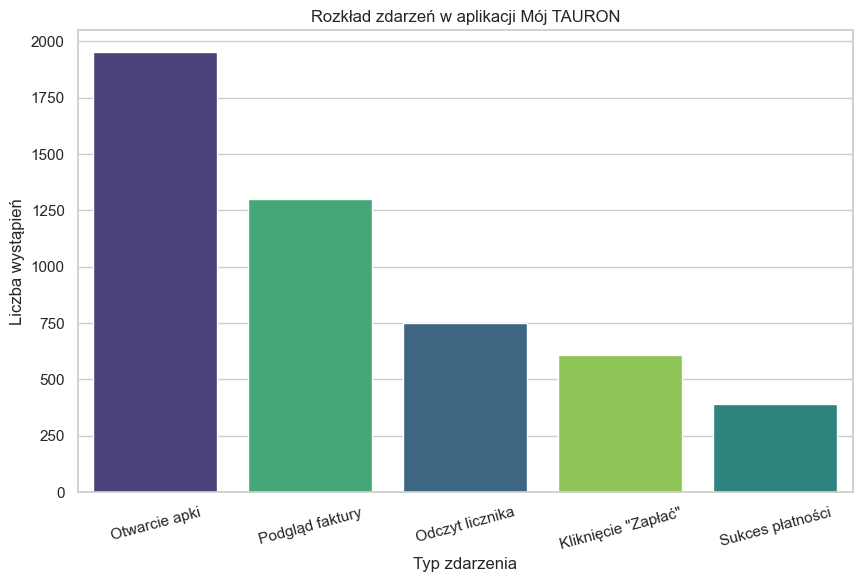

In [ ]:
sns.set_theme(style="whitegrid") # Ustawienie stylu wykresów na "whitegrid" za pomocą biblioteki Seaborn
plt.figure(figsize=(10, 6)) # Ustawienie rozmiaru wykresu na 10x6 cali
sns.countplot(data=df, x='event_name', order=lista_zdarzen, hue='event_name', palette='viridis') # Tworzenie wykresu słupkowego (countplot) z kolumny 'event_name' w DataFrame 'df', z określeniem kolejności zdarzeń i palety kolorów
etykiety_pl = ['Otwarcie apki', 'Podgląd faktury', 'Odczyt licznika', 'Kliknięcie "Zapłać"', 'Sukces płatności'] # Lista etykiet w języku polskim odpowiadających zdarzeniom w 'lista_zdarzen'
plt.xticks(ticks=range(len(lista_zdarzen)), labels=etykiety_pl, rotation=15) # Ustawienie etykiet osi X na polskie odpowiedniki zdarzeń, z rotacją 15 stopni dla lepszej czytelności
plt.title('Rozkład zdarzeń w aplikacji Mój TAURON') # Ustawienie tytułu wykresu na "Rozkład zdarzeń w aplikacji Mój TAURON"
plt.xlabel('Typ zdarzenia') # Ustawienie etykiety osi X na "Typ zdarzenia"
plt.ylabel('Liczba wystąpień') # Ustawienie etykiety osi Y na "Liczba wystąpień"
plt.show()

### Analiza Współczynnika Konwersji (Conversion Rate - CR)
Obliczam, jaki procent użytkowników, którzy zainicjowali sesję (zdarzenie app_open), pomyślnie zakończył proces płatności (payment_success). Ten wskaźnik pozwala ocenić ogólną skuteczność kanału cyfrowego.

In [61]:
uzytkownicy_otwarli = df[df['event_name'] == 'app_open']['user_id'].nunique() # Obliczanie liczby unikalnych użytkowników, którzy otworzyli aplikację (event_name == 'app_open') za pomocą nunique() na kolumnie 'user_id'
print(f"Liczba unikatowych użytkowników którzy otwarli aplikację: {uzytkownicy_otwarli}")
uzytkownicy_zaplacili = df[df['event_name'] == 'payment_success']['user_id'].nunique() # Obliczanie liczby unikalnych użytkowników, którzy dokonali płatności (event_name == 'payment_success') za pomocą nunique() na kolumnie 'user_id'
print(f"Liczba unikatowych użytkowników którzy zapłacili fakturę w aplikacji: {uzytkownicy_zaplacili}")
konwersja = (uzytkownicy_zaplacili / uzytkownicy_otwarli) * 100 # Obliczanie współczynnika konwersji jako procent użytkowników, którzy dokonali płatności w stosunku do tych, którzy otworzyli aplikację

print(f"Ogólna konwersja w aplikacji: {konwersja:.2f}%") # Wyświetlanie ogólnej konwersji w aplikacji z dwoma miejscami po przecinku

Liczba unikatowych użytkowników którzy otwarli aplikację: 485
Liczba unikatowych użytkowników którzy zapłacili fakturę w aplikacji: 269
Ogólna konwersja w aplikacji: 55.46%


### Kluczowe spostrzeżenie:
Ogólna konwersja wynosi 55.46%. Warto zauważyć, że największy spadek użytkowników (drop-off) następuje na etapie podawania odczytu licznika. Sugeruje to potrzebę uproszczenia formularza w tym kroku.

### Mapa Ciepła: Rozkład Zdarzeń na Platformach
Poniższa mapa ciepła przedstawia wolumen akcji na różnych platformach. Uporządkowanie kolumn zgodnie ze ścieżką użytkownika (lejek) pozwala wizualnie zidentyfikować momenty, w których klienci rezygnują z dalszych kroków.

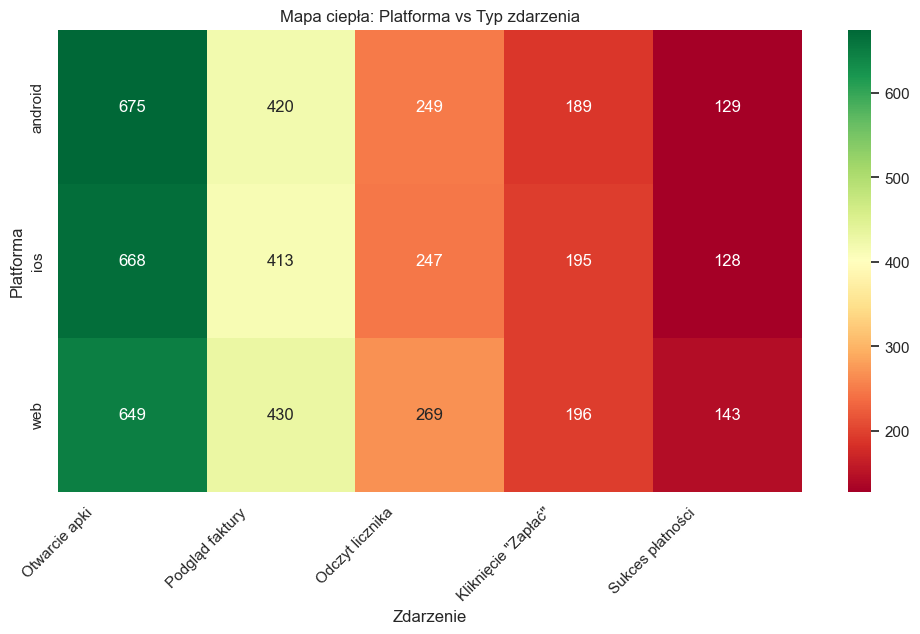

In [90]:
analiza_platform = pd.crosstab(df['platform'], df['event_name'])
analiza_platform = analiza_platform[lista_zdarzen]
analiza_platform

plt.figure(figsize=(12, 6)) # Ustawienie rozmiaru wykresu na 12x6 cali
sns.heatmap(analiza_platform, annot=True, fmt="d", cmap="RdYlGn") 
etykiety_pl = ['Otwarcie apki', 'Podgląd faktury', 'Odczyt licznika', 'Kliknięcie "Zapłać"', 'Sukces płatności']
plt.xticks(ticks=range(len(lista_zdarzen)), labels=etykiety_pl, rotation=45)
plt.title('Mapa ciepła: Platforma vs Typ zdarzenia')
plt.ylabel('Platforma')
plt.xlabel('Zdarzenie')
plt.show()

### Analiza: Obliczanie współczynnika konwersji ze względu na platformę użytkownika

In [84]:
konwersja_platformy = (analiza_platform['payment_success'] / analiza_platform['app_open']) * 100
print("Współczynnik konwersji wg platform [%]:")
display(konwersja_platformy.sort_values(ascending=False).map(lambda x: f"{x:.2f}%"))

Współczynnik konwersji wg platform [%]:


platform
web        22.03%
ios        19.16%
android    19.11%
dtype: object

#### &rarr; Użytkownicy wersji przeglądarkowej (Web) mają o ponad 8 punktów procentowych niższą konwersję niż użytkownicy iOS. Sugeruje to bariery w procesie płatności na komputerach stacjonarnych lub mniej intuicyjny interfejs portalu klienta w porównaniu do aplikacji mobilnych.

### Analiza Trendu Dziennego
Monitorowanie codziennej aktywności użytkowników pozwala na szybkie wykrycie anomalii technicznych (np. awarii systemu) oraz zrozumienie sezonowości korzystania z aplikacji. Stabilna linia trendu świadczy o poprawnej dostępności platformy.

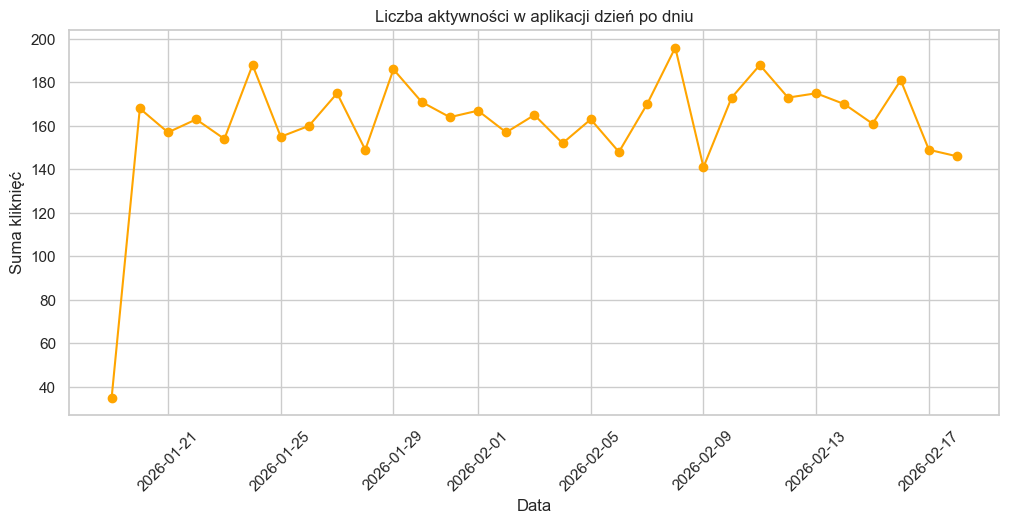

In [87]:
trend_dzienny = df.groupby('date_only').size() #Liczba zdarzeń każdego dnia - zliczenie

# Rysowanie wykresu liniowego przedstawiającego trend dzienny liczby zdarzeń w aplikacji
plt.figure(figsize=(12, 5))
trend_dzienny.plot(kind='line', marker='o', color='orange')
plt.title('Liczba aktywności w aplikacji dzień po dniu')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.ylabel('Suma kliknięć')
plt.grid(True)
plt.show()

## Kluczowe spostrzeżenie:
Aktywność w aplikacji utrzymuje się na stabilnym poziomie, oscylując średnio wokół 160 zdarzeń dziennie. Brak nagłych spadków (tzw. dipów) sugeruje wysoką dostępność techniczną portalu i aplikacji mobilnych w badanym okresie. Ostatni dzień wykazuje lekkie wyhamowanie, co może być wynikiem niepełnego dnia w zebranych logach i wymaga monitoringu w kolejnym cyklu raportowym.

### Business Summary & Recommendations:
+ Naprawić UX wersji Web (najniższa konwersja).
+ Zoptymalizować lejek na etapie przejścia z odczytu licznika do płatności.
+ Monitorować stabilność platformy Android, która ma najwięcej zdarzeń, ale niższą konwersję niż iOS.